# GANs (Generative Adversarial Networks)

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 658.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 790.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.7 MB/s eta 

In [2]:
# Import libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary
from torch_snippets import *

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Wed Apr  3 00:43:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [15]:
# Set up a normalization transform for the images
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [16]:
# Create a DataLoader for the MNIST dataset
dataloader = DataLoader(
    MNIST('~/data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True, drop_last=True)

In [17]:
# Create a class for the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

In [18]:
# Create a mock-up Discriminator model and print summary
discriminator = Discriminator().to(device)
summary(discriminator, torch.zeros(1, 784))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 1024]                803,840
|    └─LeakyReLU: 2-2                    [-1, 1024]                --
|    └─Dropout: 2-3                      [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─LeakyReLU: 2-5                    [-1, 512]                 --
|    └─Dropout: 2-6                      [-1, 512]                 --
|    └─Linear: 2-7                       [-1, 256]                 131,328
|    └─LeakyReLU: 2-8                    [-1, 256]                 --
|    └─Dropout: 2-9                      [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 1]                   257
|    └─Sigmoid: 2-11                     [-1, 1]                   --
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable par

In [19]:
# Create a class for the Generator model
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh())

    def forward(self, x):
        return self.model(x)

In [20]:
# Create a mock-up Generator model and print summary
generator = Generator().to(device)
summary(generator, torch.zeros(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 256]                 25,856
|    └─LeakyReLU: 2-2                    [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 512]                 131,584
|    └─LeakyReLU: 2-4                    [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 1024]                525,312
|    └─LeakyReLU: 2-6                    [-1, 1024]                --
|    └─Linear: 2-7                       [-1, 784]                 803,600
|    └─Tanh: 2-8                         [-1, 784]                 --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (M): 2.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.67
Estimated Total Size (MB): 5.69

In [21]:
# Create a function to generate random noise
def noise(size):
    noise = torch.randn(size, 100)
    return noise.to(device)

In [22]:
# Create a function to train the Discriminator
def train_discriminator(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    real_data, fake_data = data
    prediction_real = model(real_data)
    error_real = criterion(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = model(fake_data)
    error_fake = criterion(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    optimizer.step()
    return error_real + error_fake

# Create a function to train the Generator
def train_generator(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    real_data, fake_data = data
    prediction = model(fake_data)
    error = criterion(prediction, torch.ones(len(real_data), 1).to(device))
    error.backward()
    optimizer.step()
    return error

EPOCH: 1.000  d_loss: 1.031  g_loss: 2.349  (16.93s - 3368.83s remaining)
EPOCH: 2.000  d_loss: 1.294  g_loss: 1.258  (33.66s - 3332.52s remaining)
EPOCH: 3.000  d_loss: 1.227  g_loss: 1.162  (49.85s - 3273.52s remaining)
EPOCH: 4.000  d_loss: 1.084  g_loss: 1.791  (66.50s - 3258.61s remaining)
EPOCH: 5.000  d_loss: 0.628  g_loss: 2.307  (83.07s - 3239.66s remaining)
EPOCH: 6.000  d_loss: 0.537  g_loss: 3.306  (99.34s - 3212.13s remaining)
EPOCH: 7.000  d_loss: 0.681  g_loss: 2.535  (116.36s - 3208.13s remaining)
EPOCH: 8.000  d_loss: 0.547  g_loss: 2.841  (132.69s - 3184.65s remaining)
EPOCH: 9.000  d_loss: 0.556  g_loss: 2.690  (149.08s - 3163.82s remaining)
EPOCH: 10.000  d_loss: 0.589  g_loss: 2.574  (165.99s - 3153.88s remaining)
EPOCH: 11.000  d_loss: 0.569  g_loss: 2.661  (183.32s - 3149.81s remaining)
EPOCH: 12.000  d_loss: 0.547  g_loss: 2.706  (199.97s - 3132.82s remaining)
EPOCH: 13.000  d_loss: 0.606  g_loss: 2.442  (216.53s - 3114.75s remaining)
EPOCH: 14.000  d_loss: 0.63

100%|██████████| 301/301 [00:09<00:00, 30.51it/s]


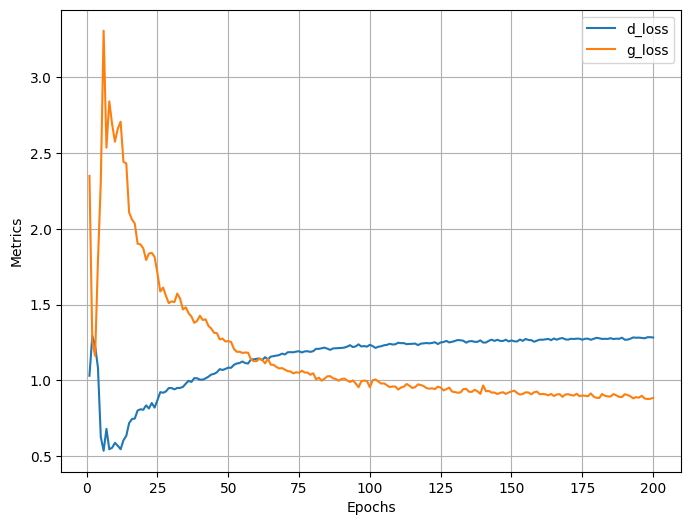

In [23]:
# Train the model
discriminator = Discriminator().to(device)
generator = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4)
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(dataloader)
    for i, (images, _) in enumerate(dataloader):
        # Train the Discriminator
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach() # detach tensor so training discriminator does not affect generator
        d_loss = train_discriminator(discriminator, (real_data, fake_data), criterion, d_optimizer)

        # Train the Generator
        fake_data = generator(noise(len(real_data))).to(device) # regenerate fake data
        g_loss = train_generator(discriminator, (real_data, fake_data), criterion, g_optimizer)
        log.record(epoch+(i+1)/n, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

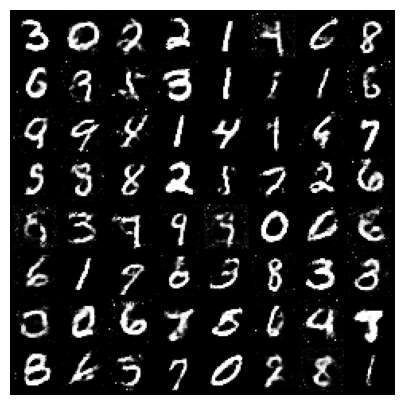

In [24]:
# Plot the generated images
noise = torch.randn(64, 100).to(device)
generated_images = generator(noise).view(64, 1, 28, 28)
grid = make_grid(generated_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)